In [55]:
import ROOT
import uproot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as LogNorm
import matplotlib.ticker as ticker
import math
from scipy.optimize import curve_fit

fileName = "../histograms/analysis_note/rho_fits.root"
outBase = "/volatile/clas12/users/jphelan/SIDIS/analysis_note/rho_scaling"
inFile = uproot.open(fileName)
inFile_R = ROOT.TFile.Open(fileName, "READ")
key = inFile.keys()

chargeSt = ['p','m']
titSt = [r"($(e, e' h^+)$",r"$(e, e' h^-)$"]


In [56]:
def eval_func_rho(params, xVal):
	if params[2] == 0:
		return 0
	return params[0]*np.exp(-.5*((xVal - params[1])/params[2])*((xVal-params[1])/params[2]))# + params[3]*math.exp(-.5*((xVal - params[4])/params[5])*((xVal-params[4])/params[5]))
def eval_func_back(params, xVal):
	if params[5] == 0:
		return 0
	return params[3]*np.exp(-.5*((xVal - params[4])/params[5])*((xVal-params[4])/params[5]))

def eval_func(xVal, *params):
	p0, p1, p2, p3, p4, p5 = params
	return p0*np.exp(-.5*((xVal - p1)/p2)*((xVal-p1)/p2)) + p3*np.exp(-.5*((xVal - p4)/p5)*((xVal-p4)/p5))


/usr/lib64/python3.9/site-packages/scipy/optimize/_minpack_py.py:803: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/usr/lib64/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


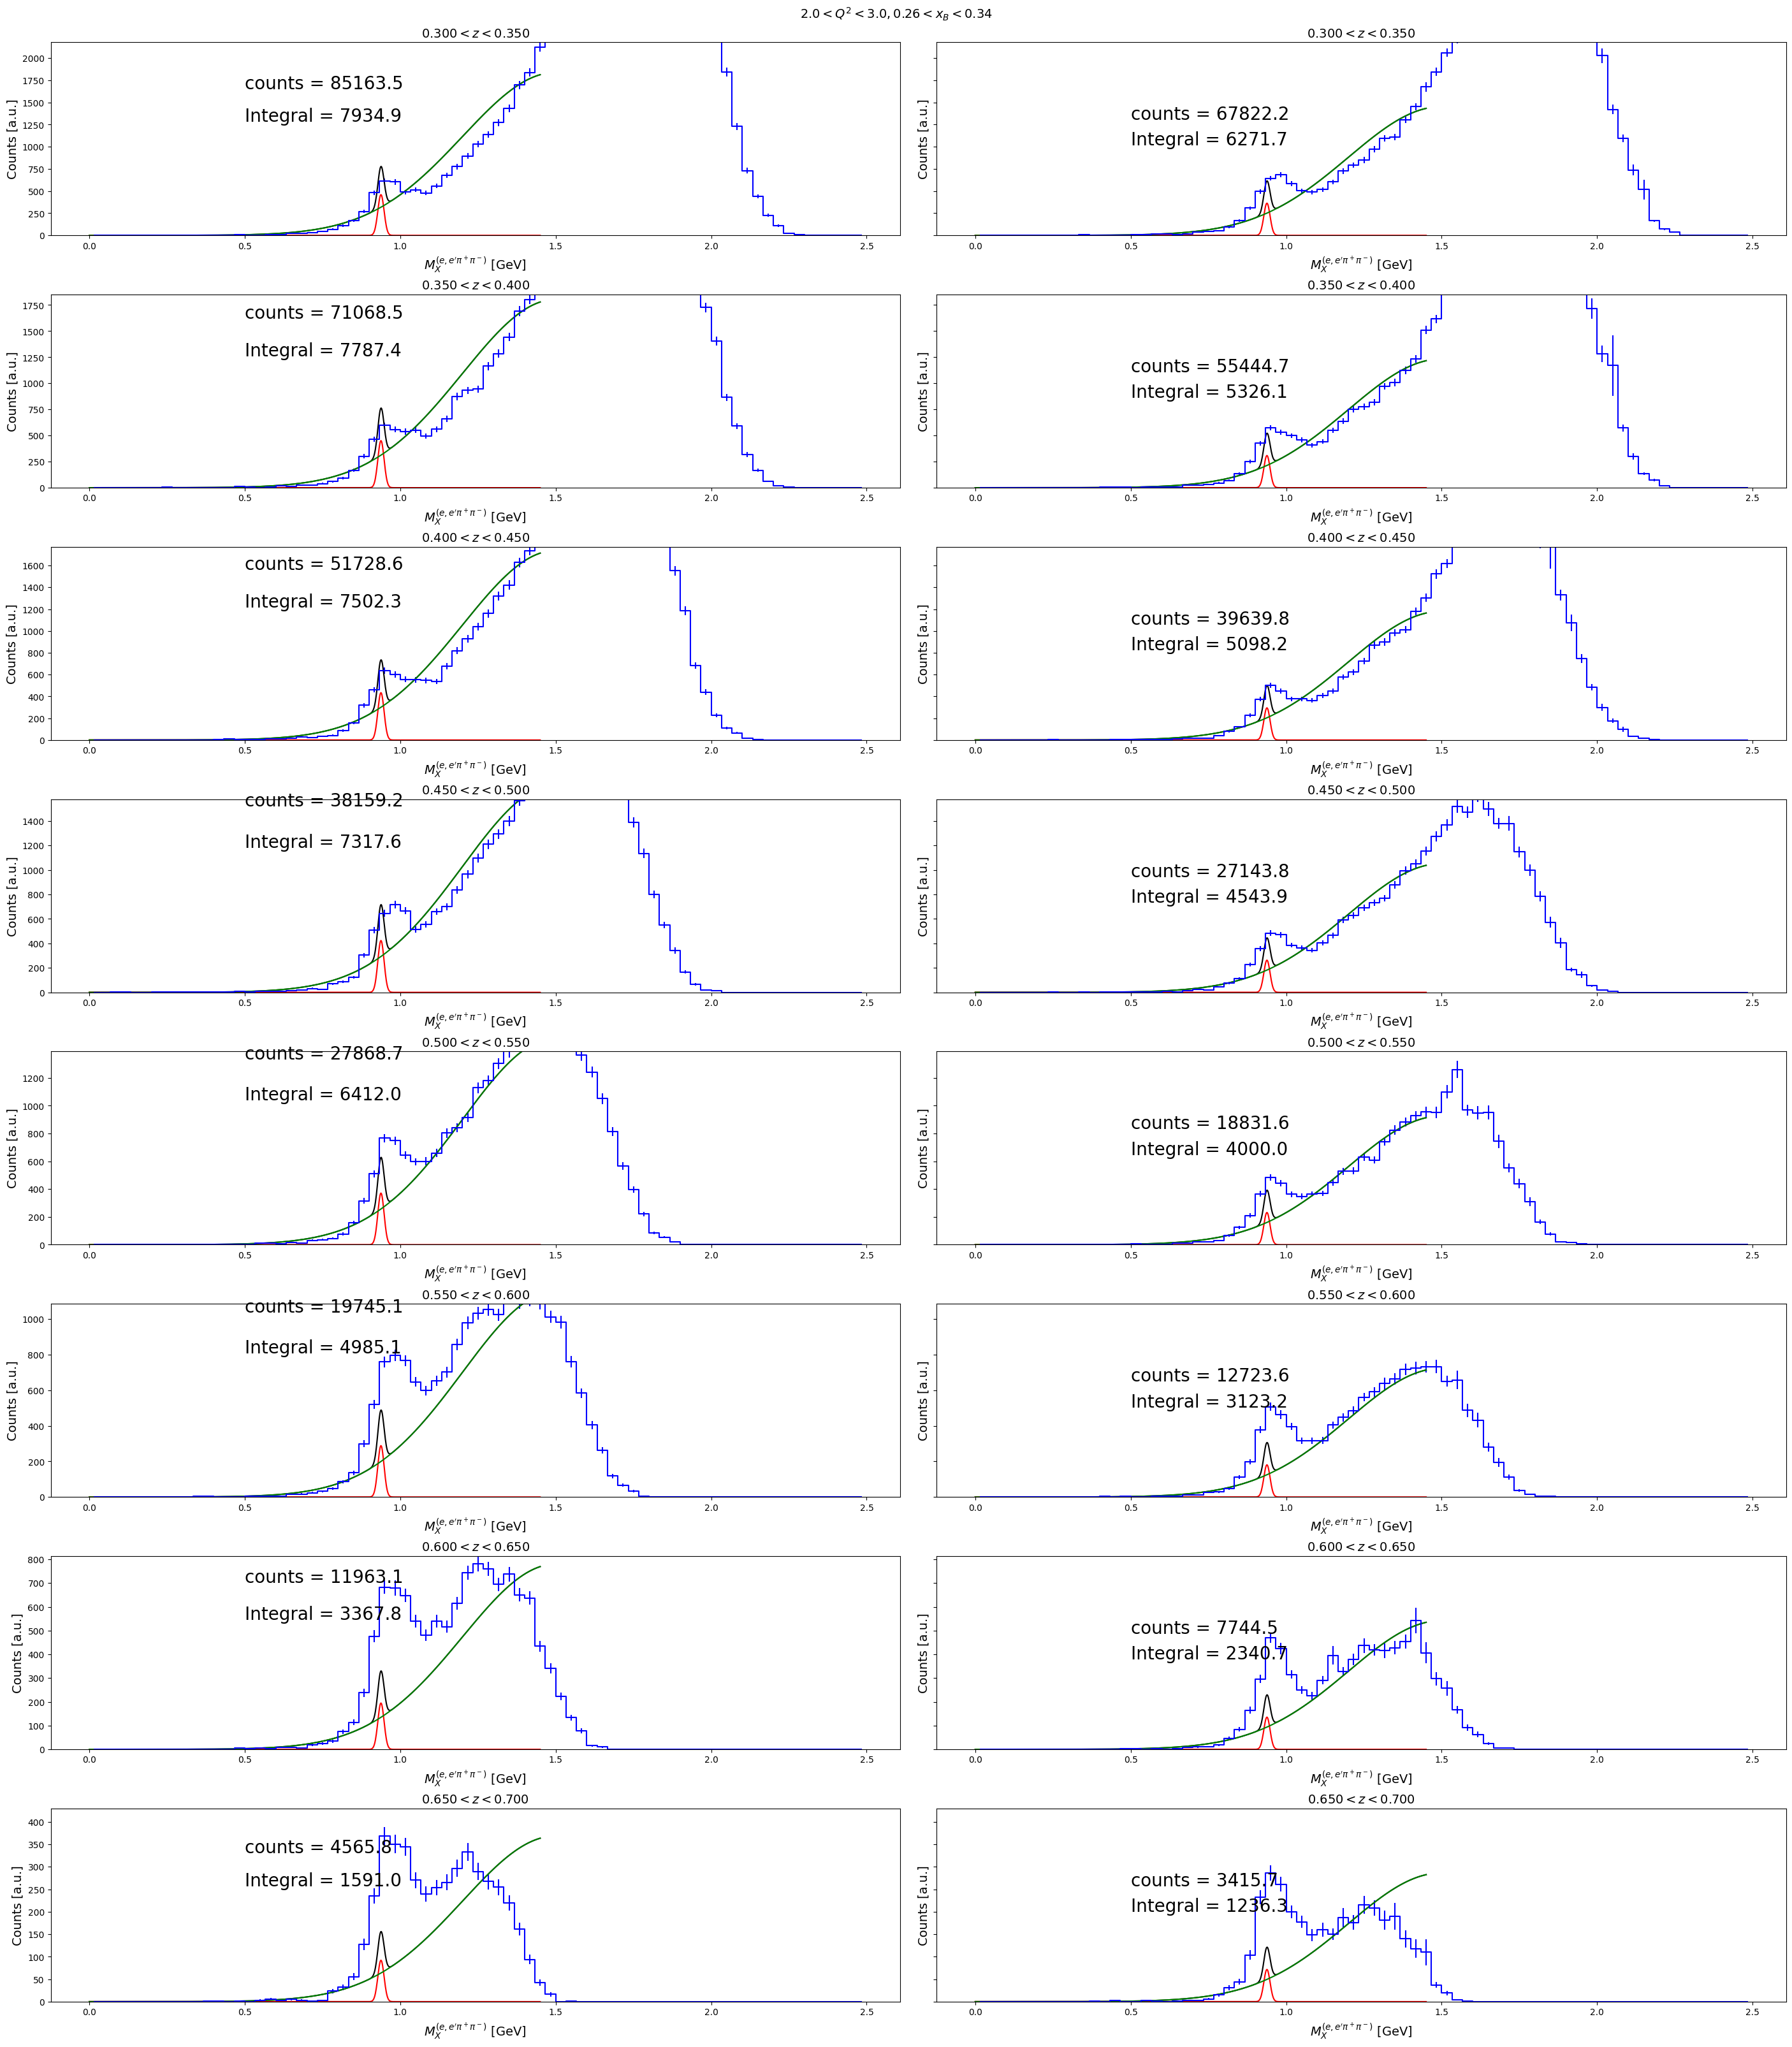

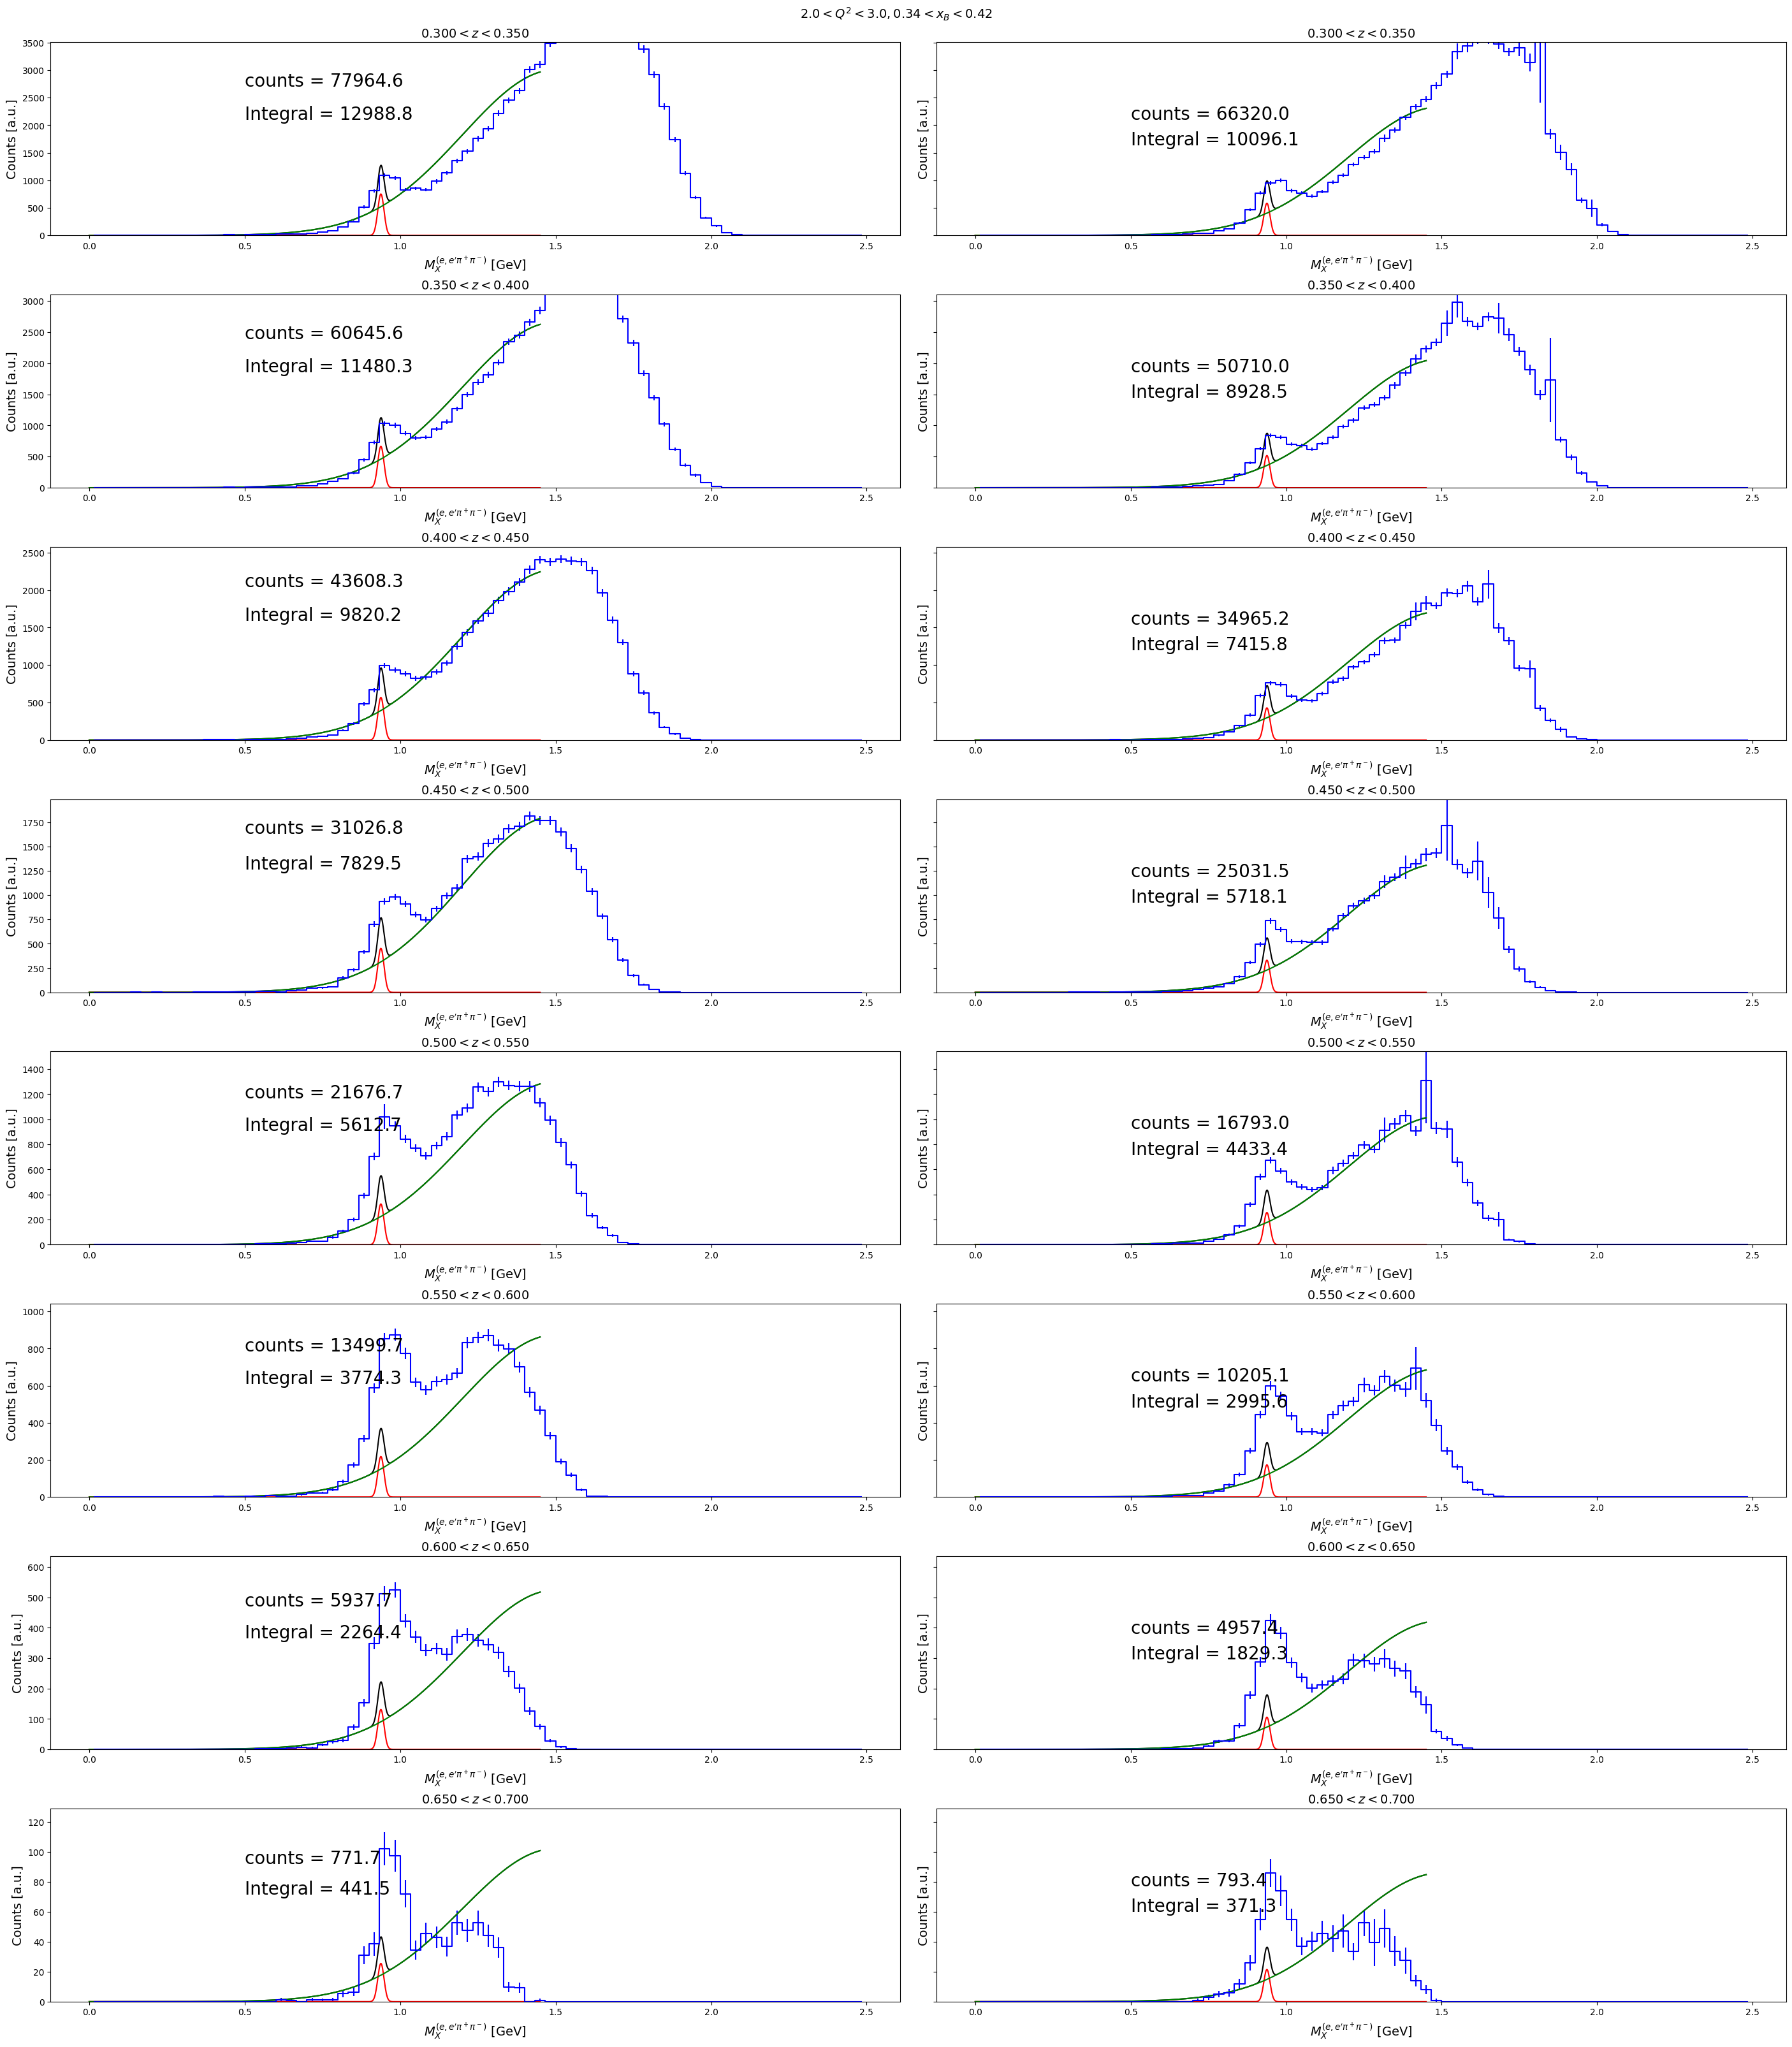

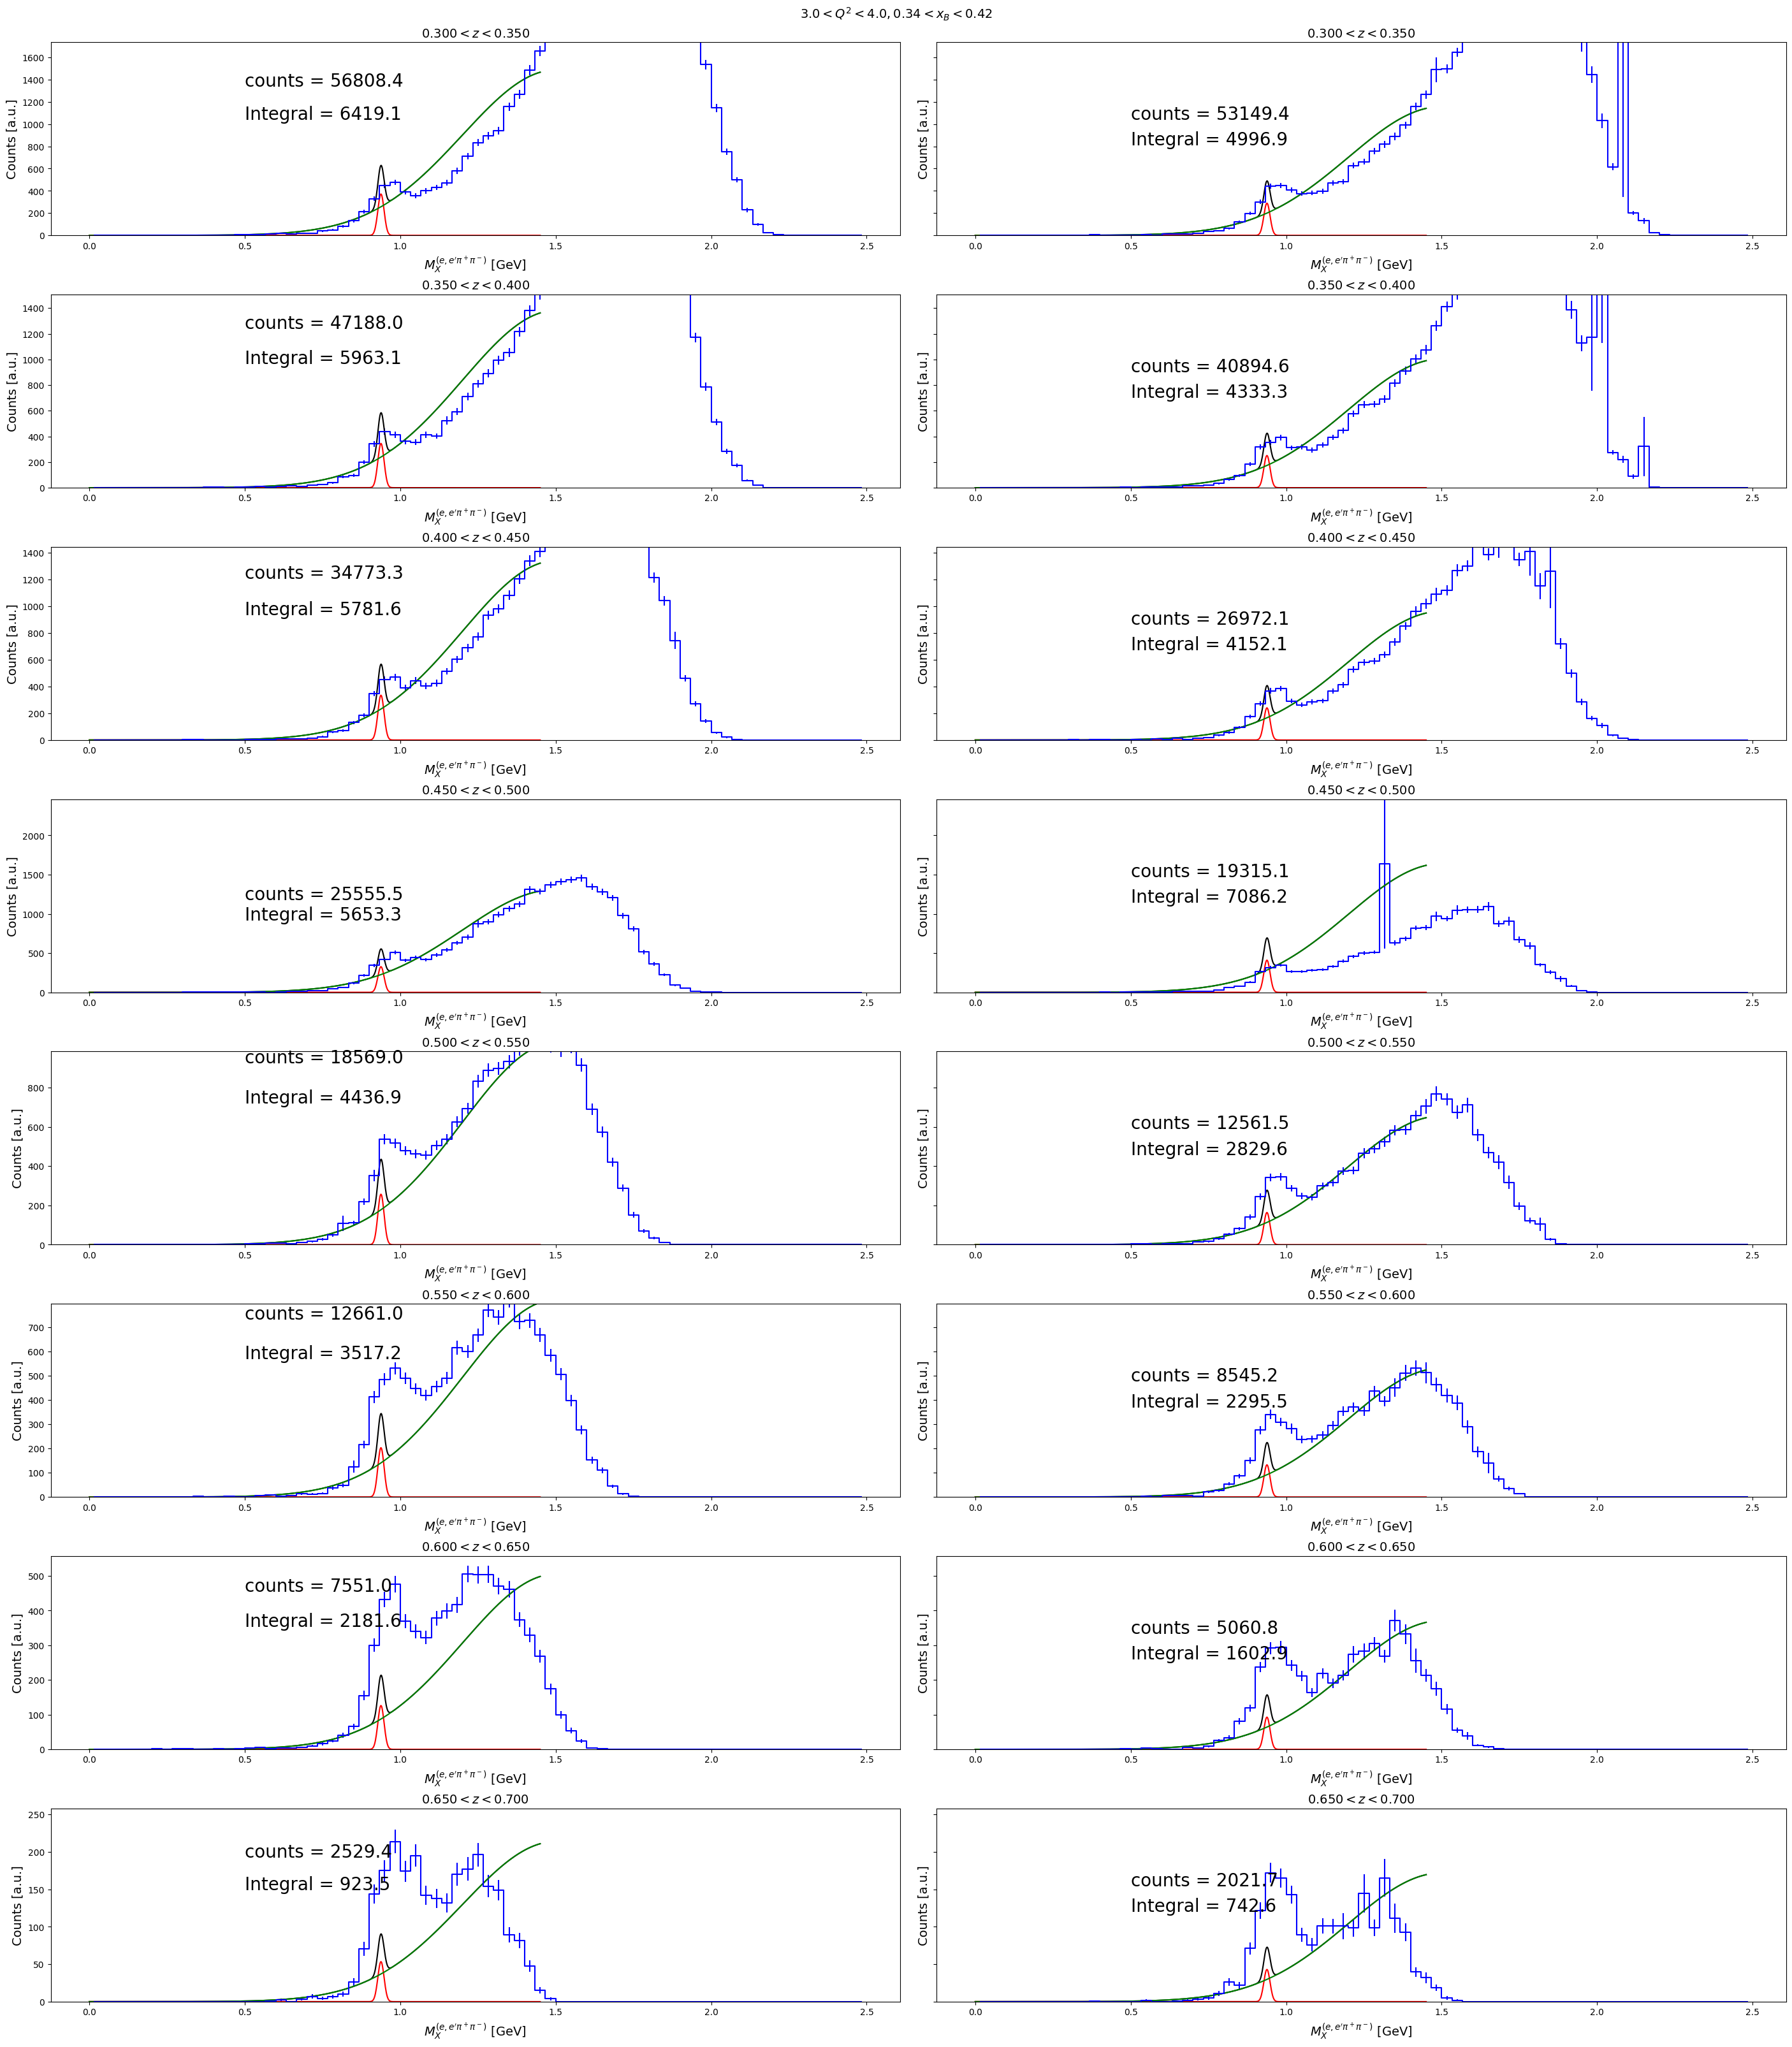

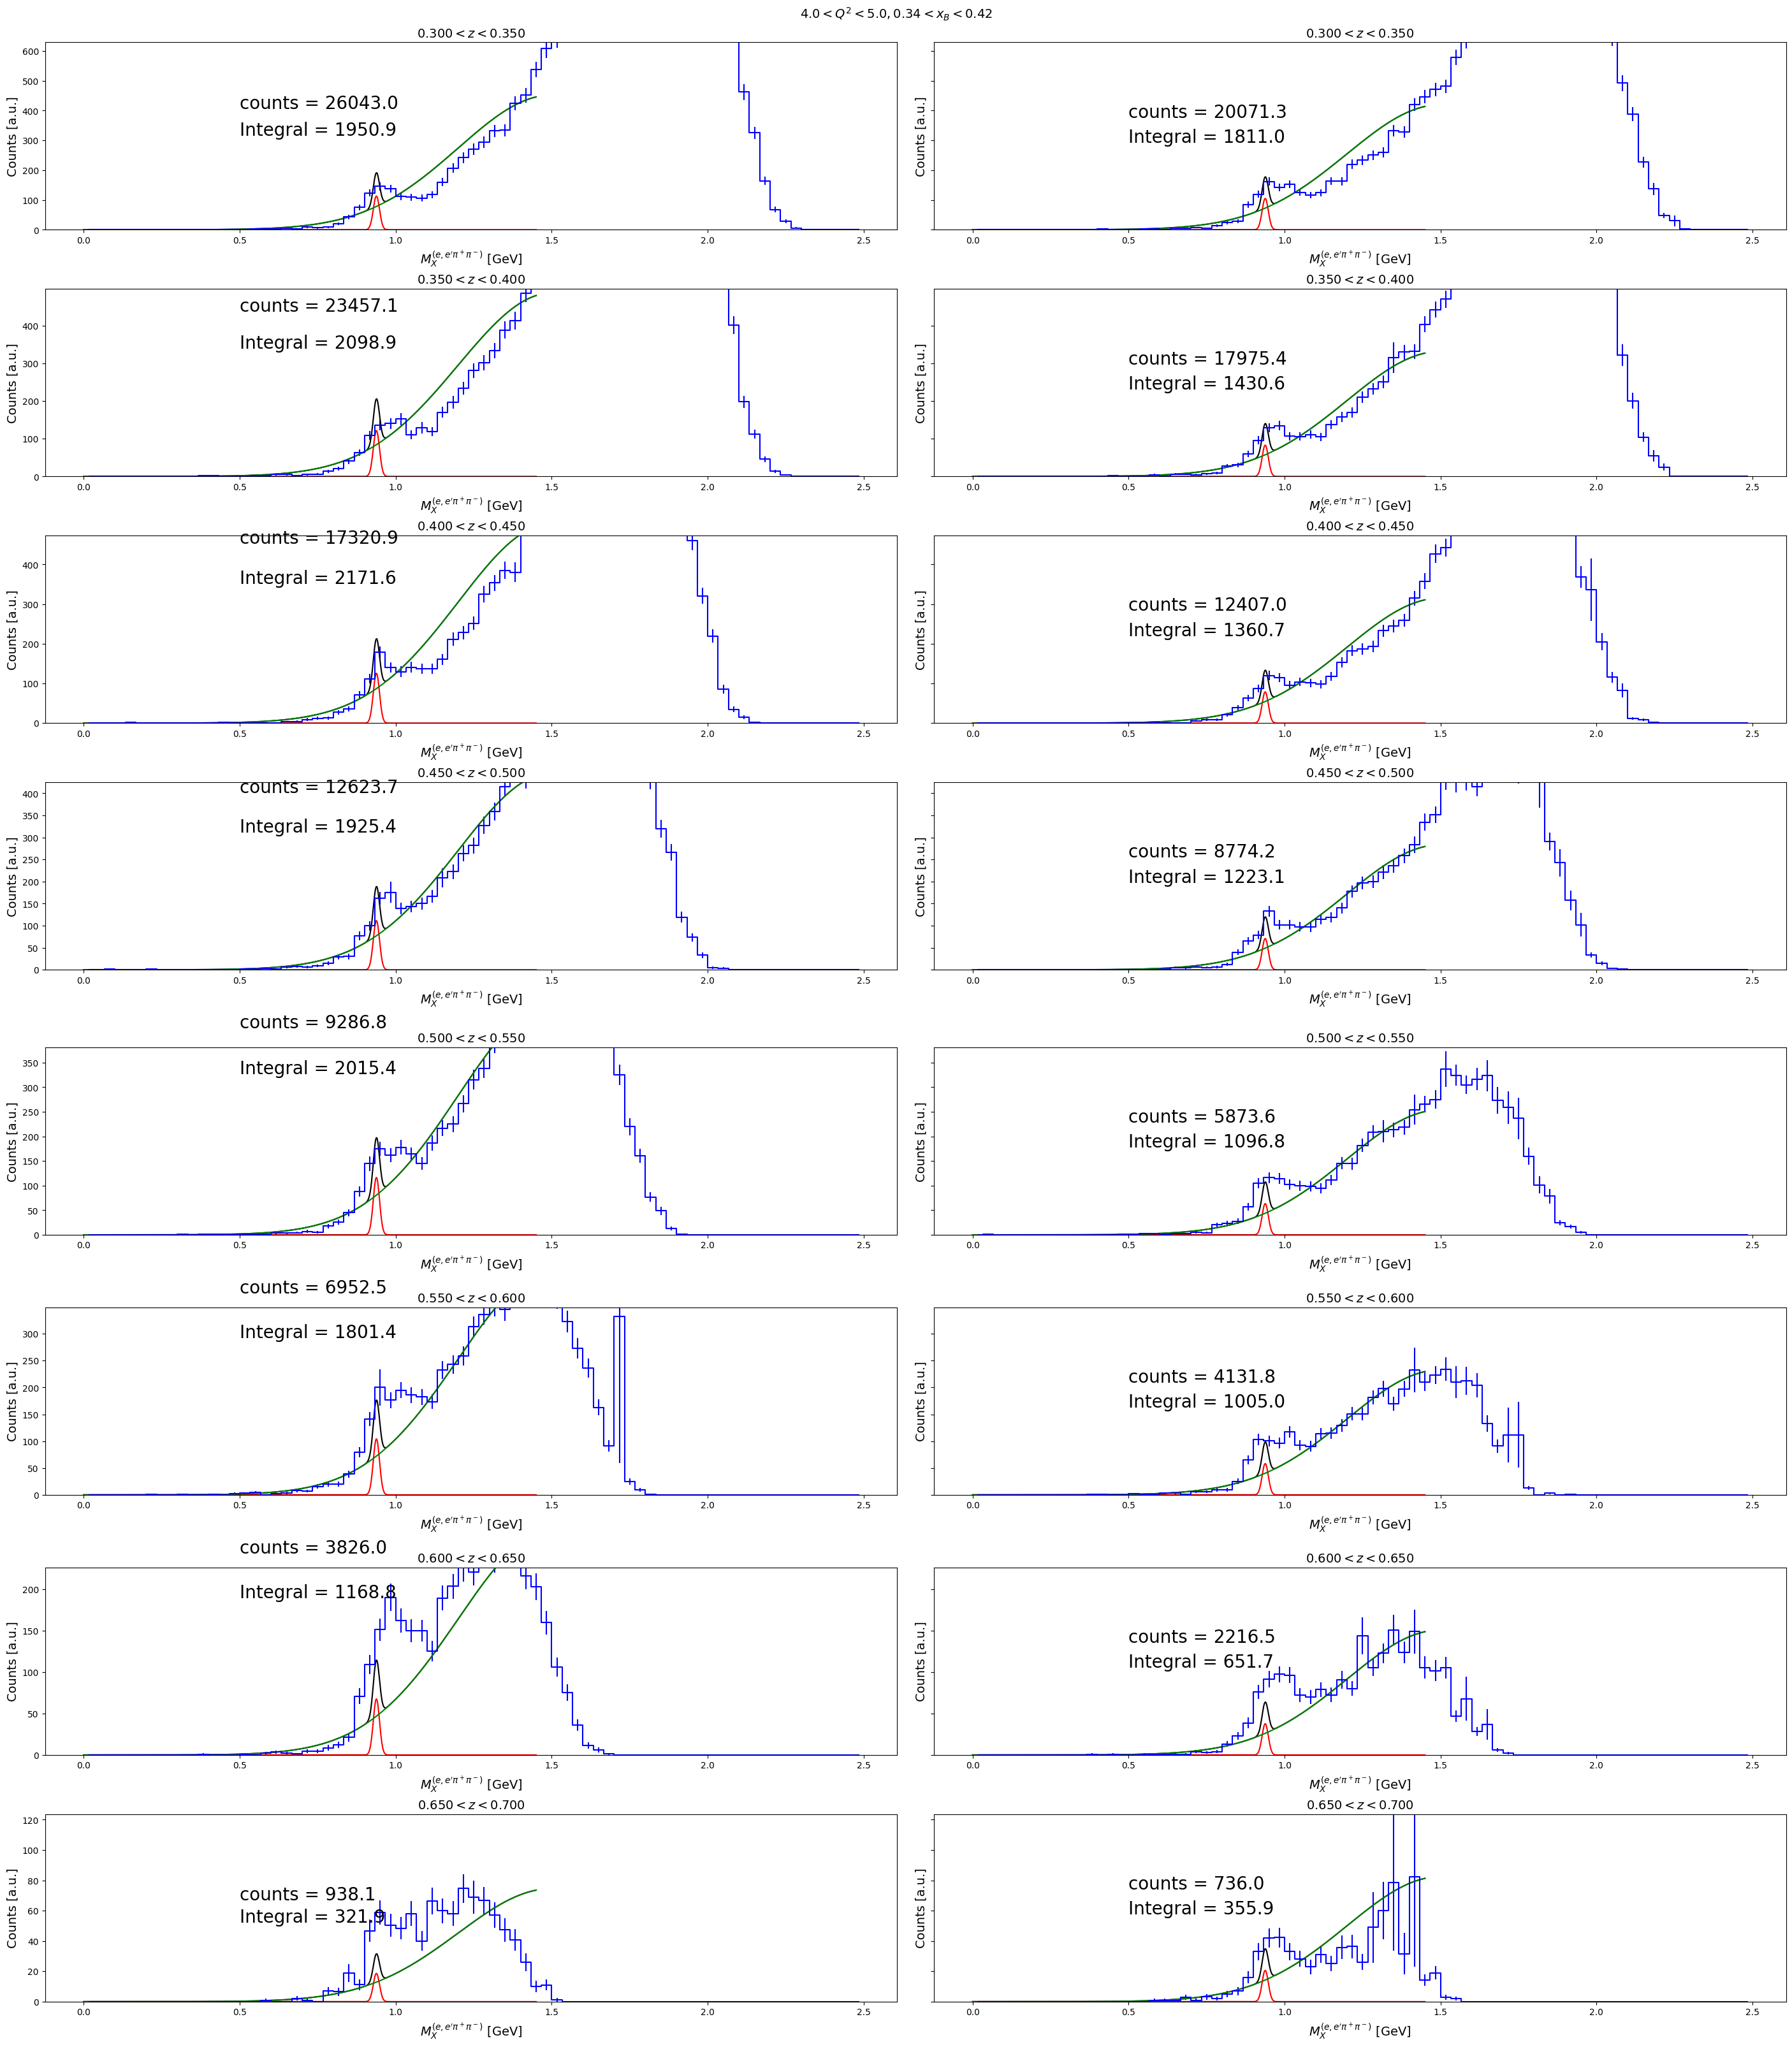

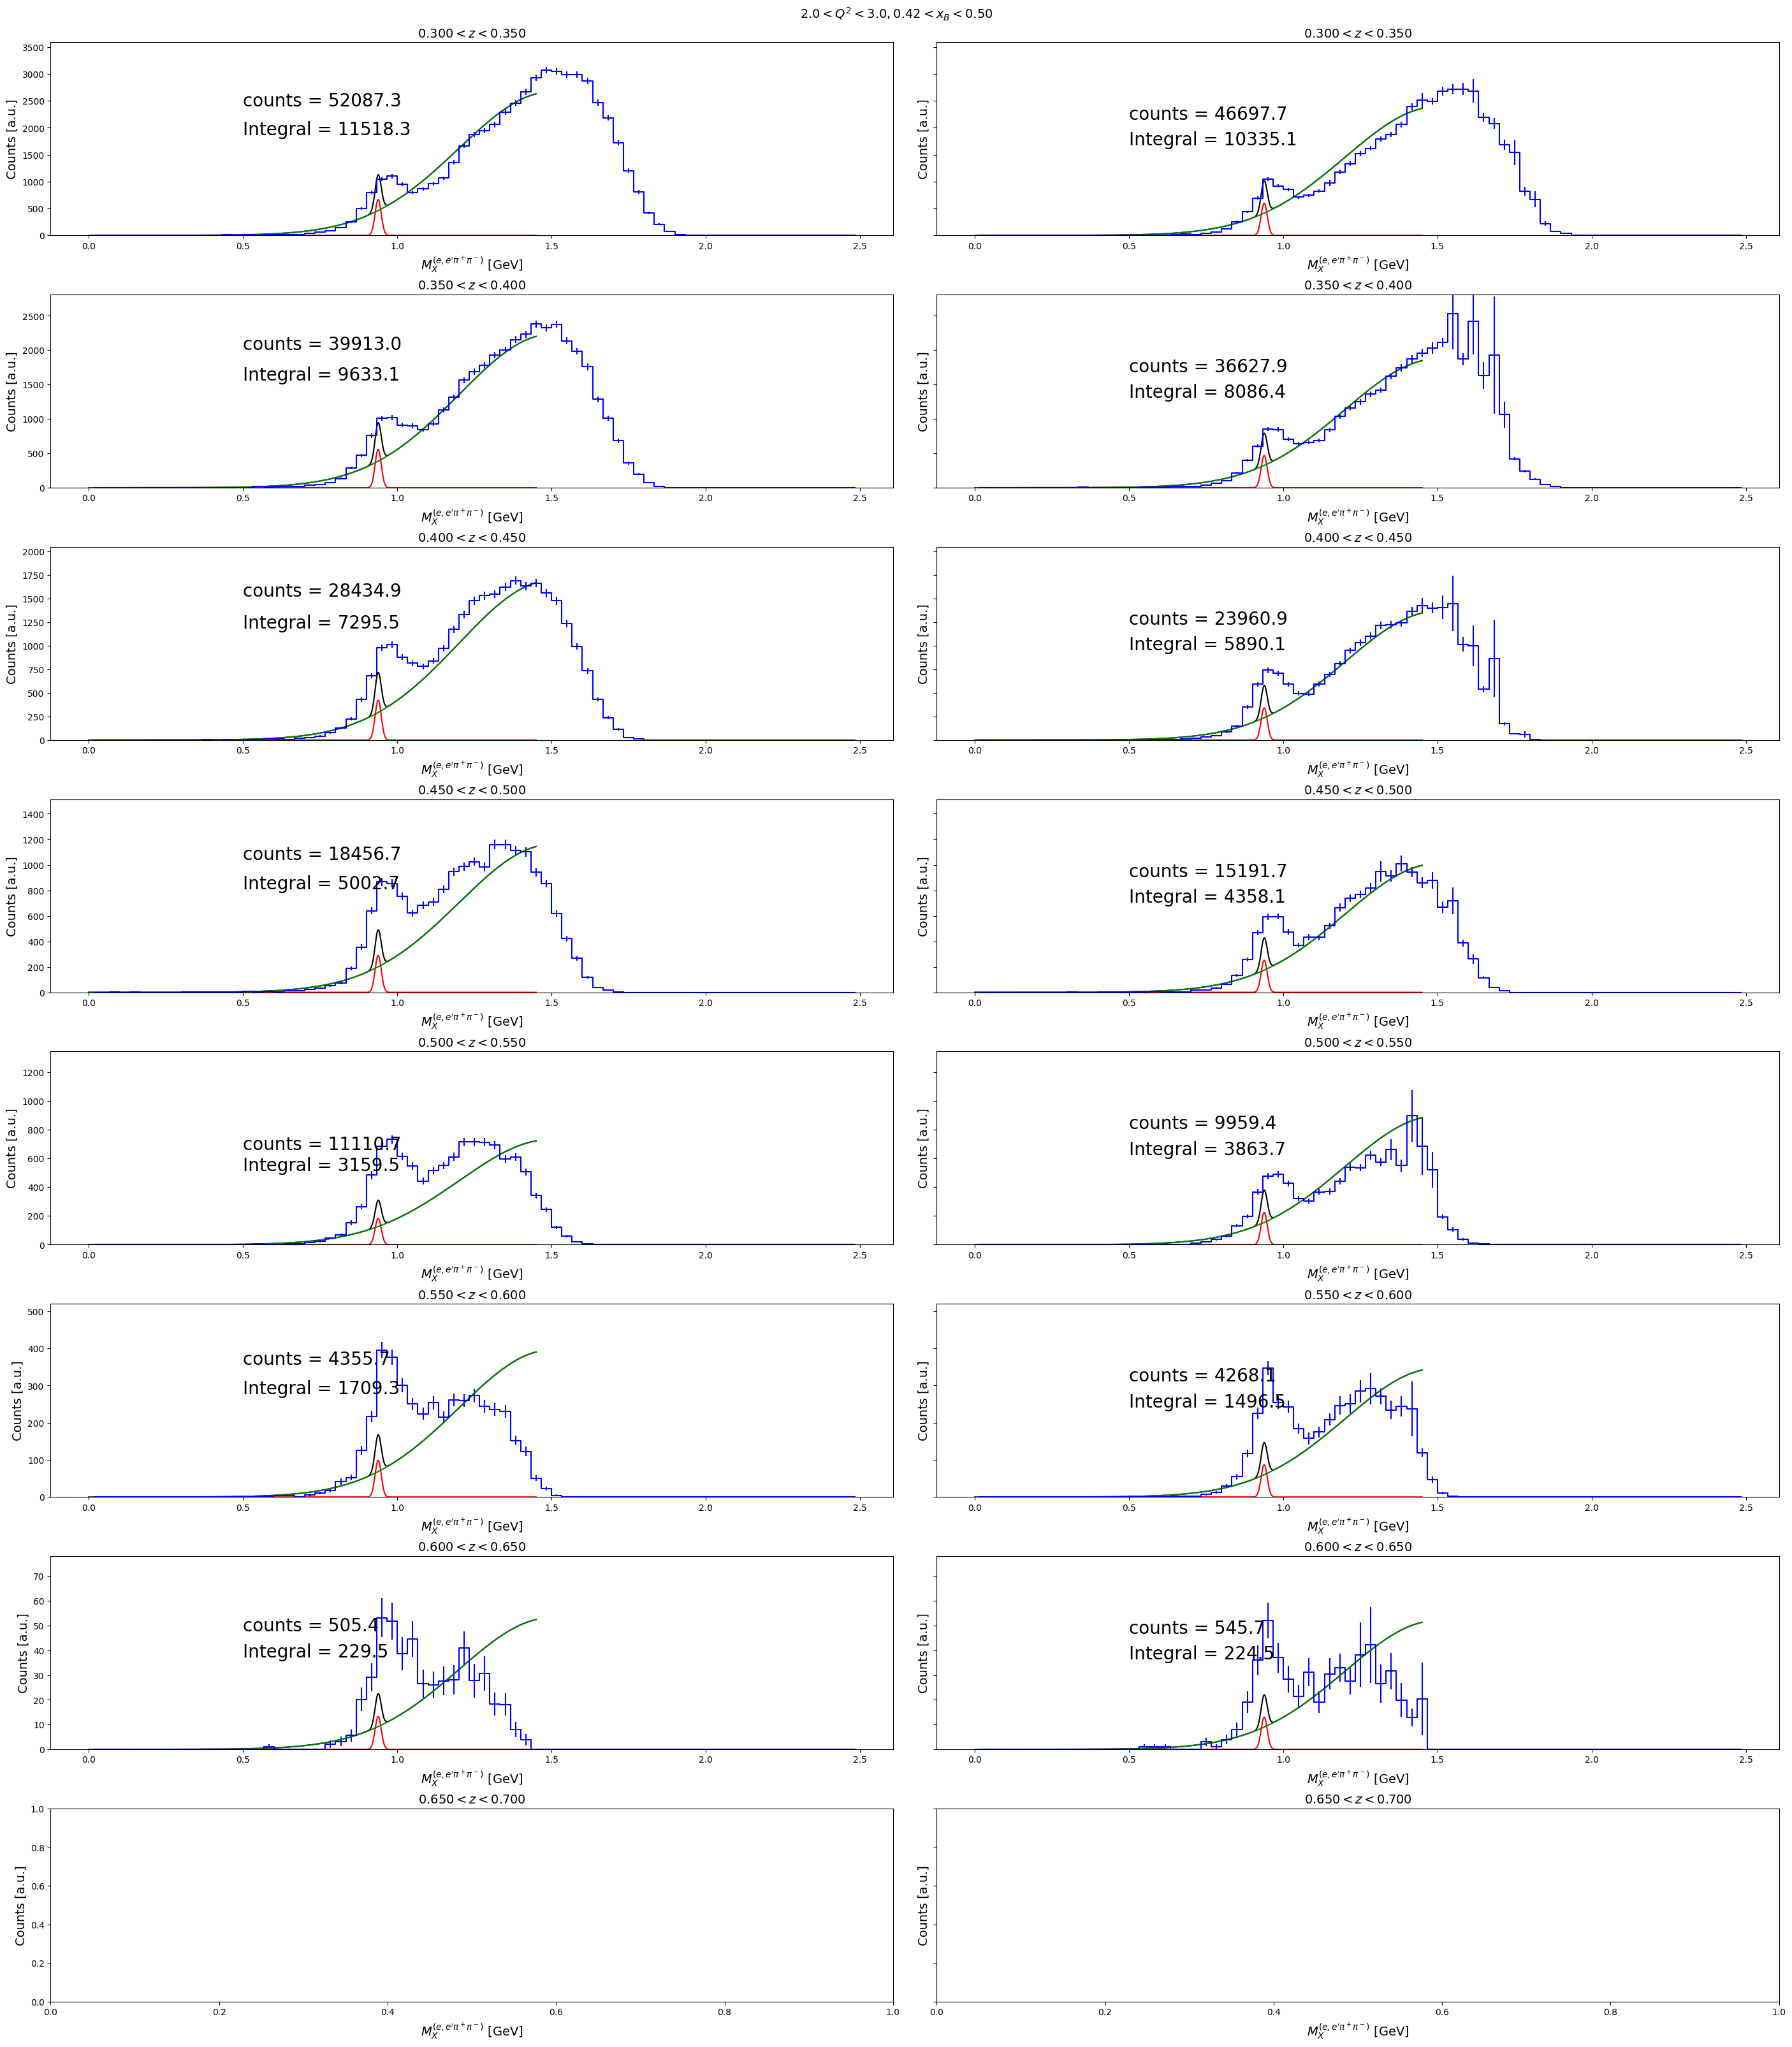

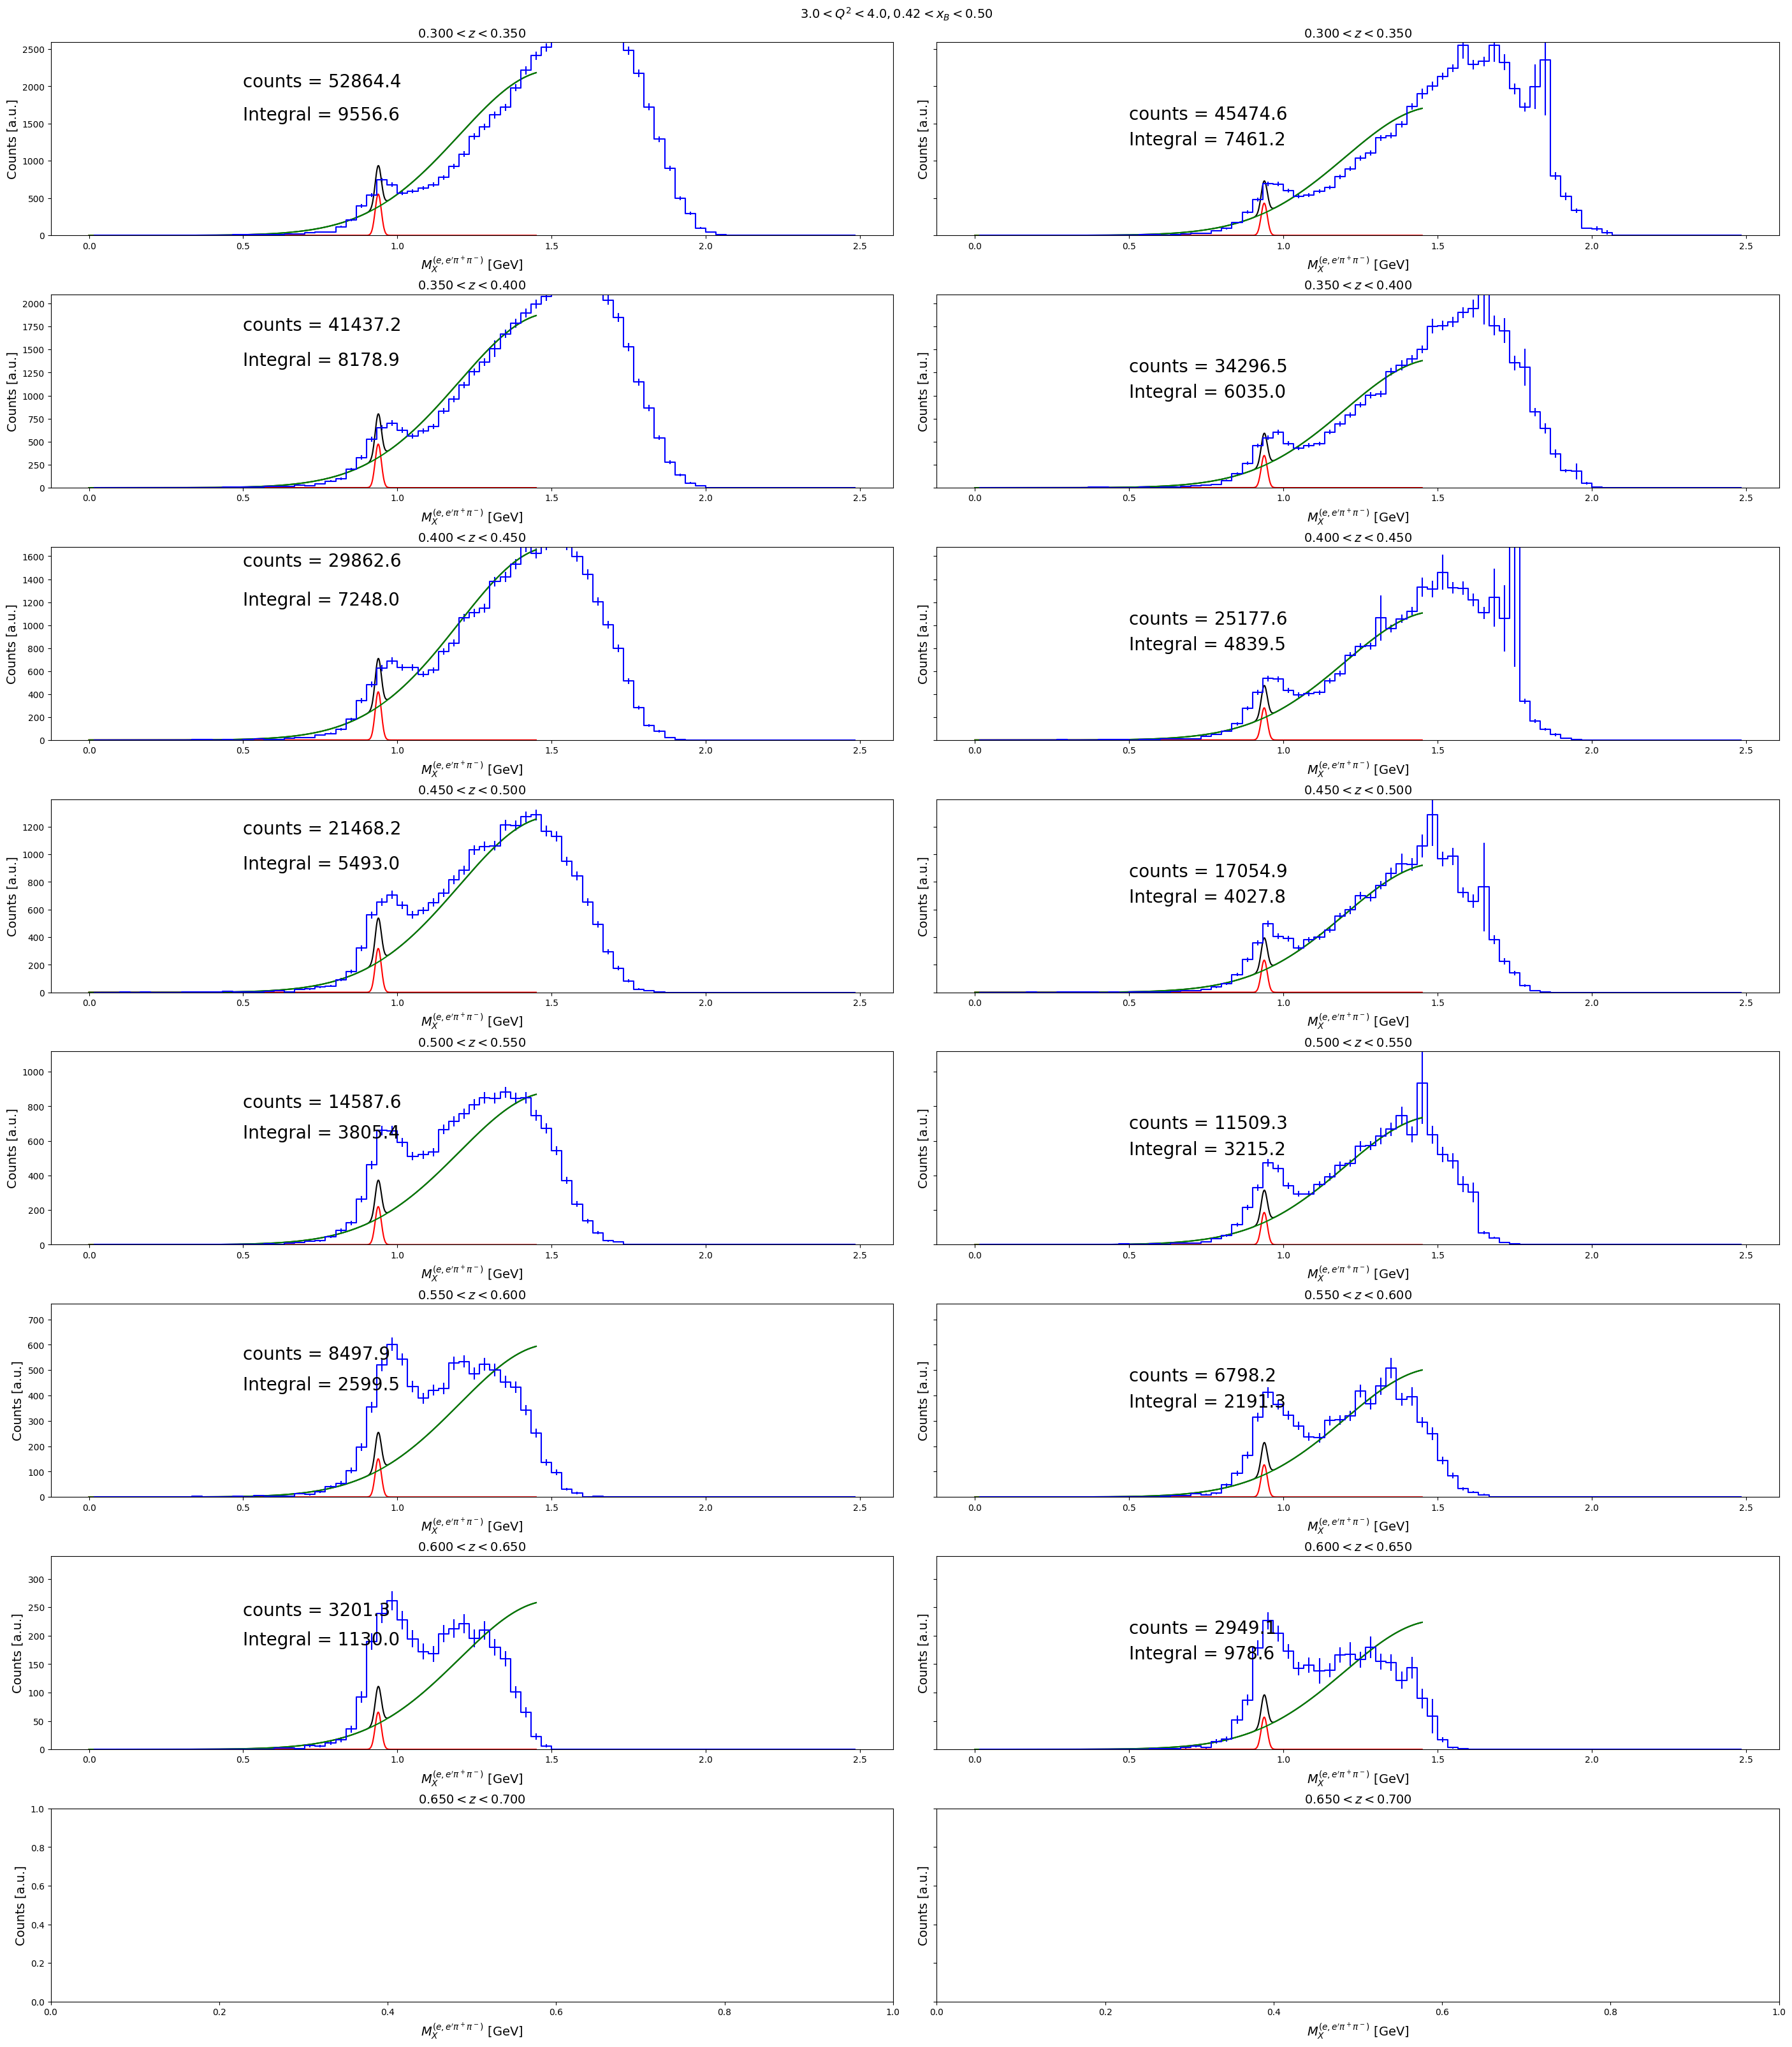

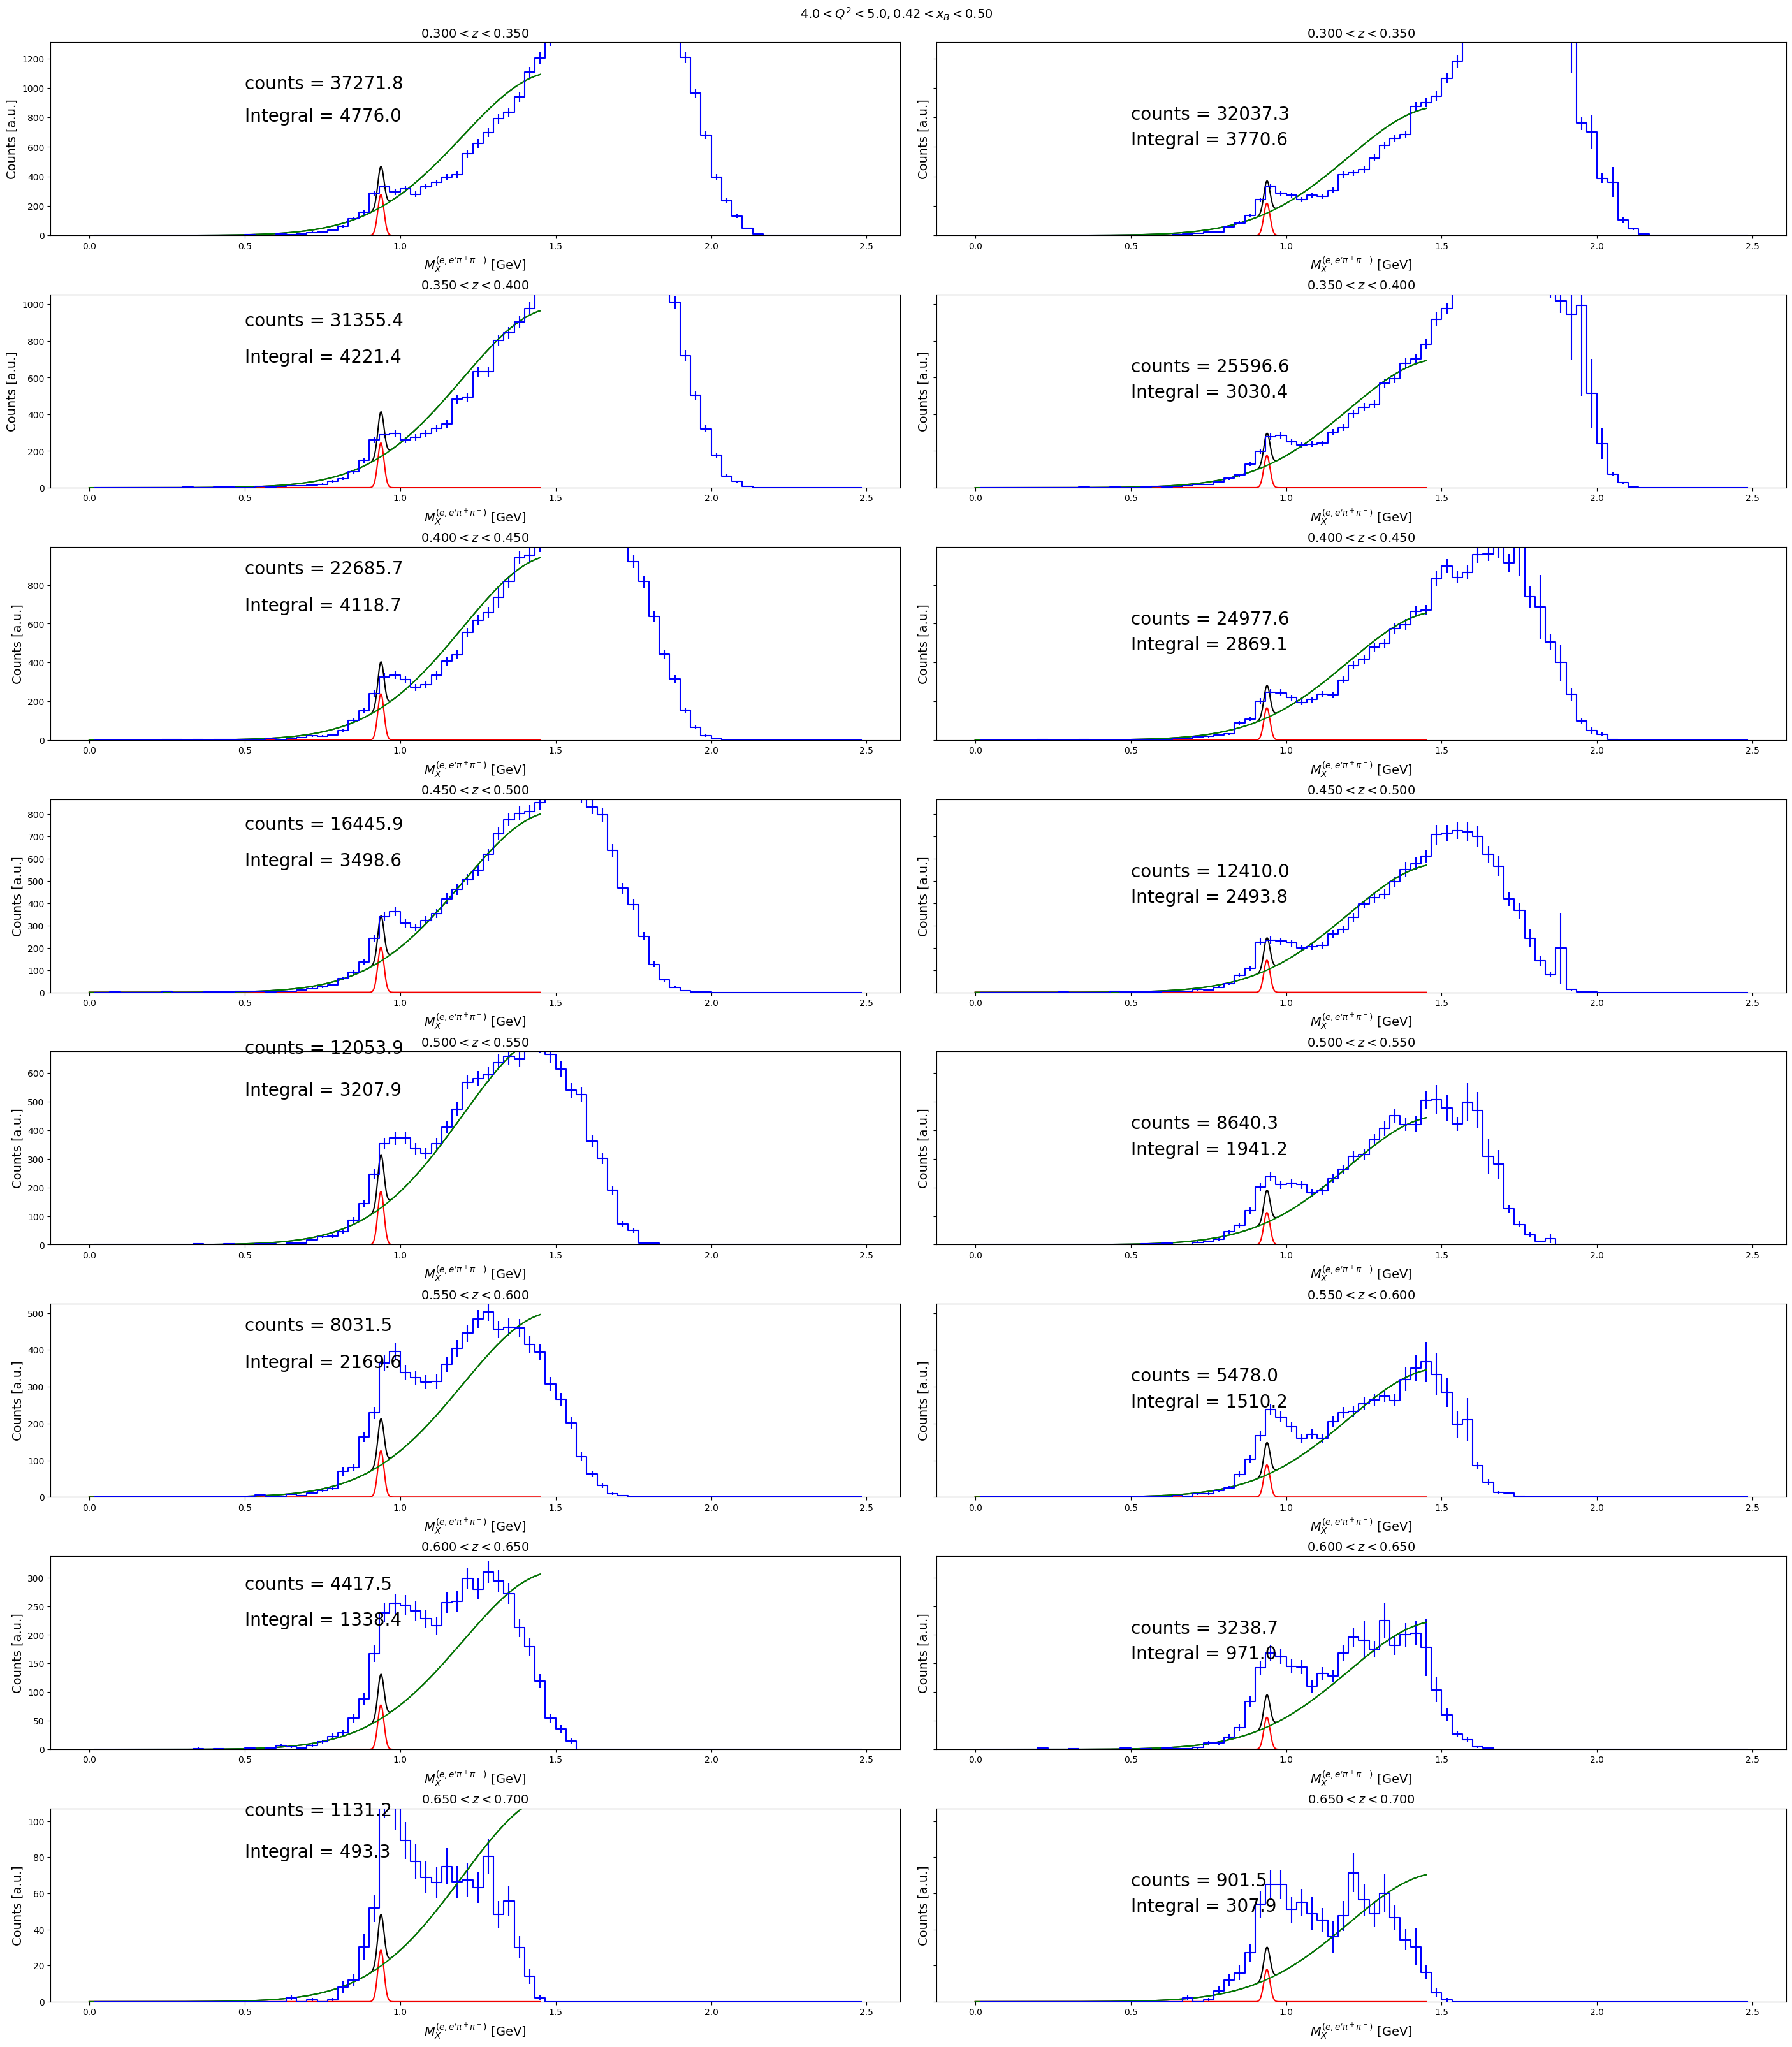

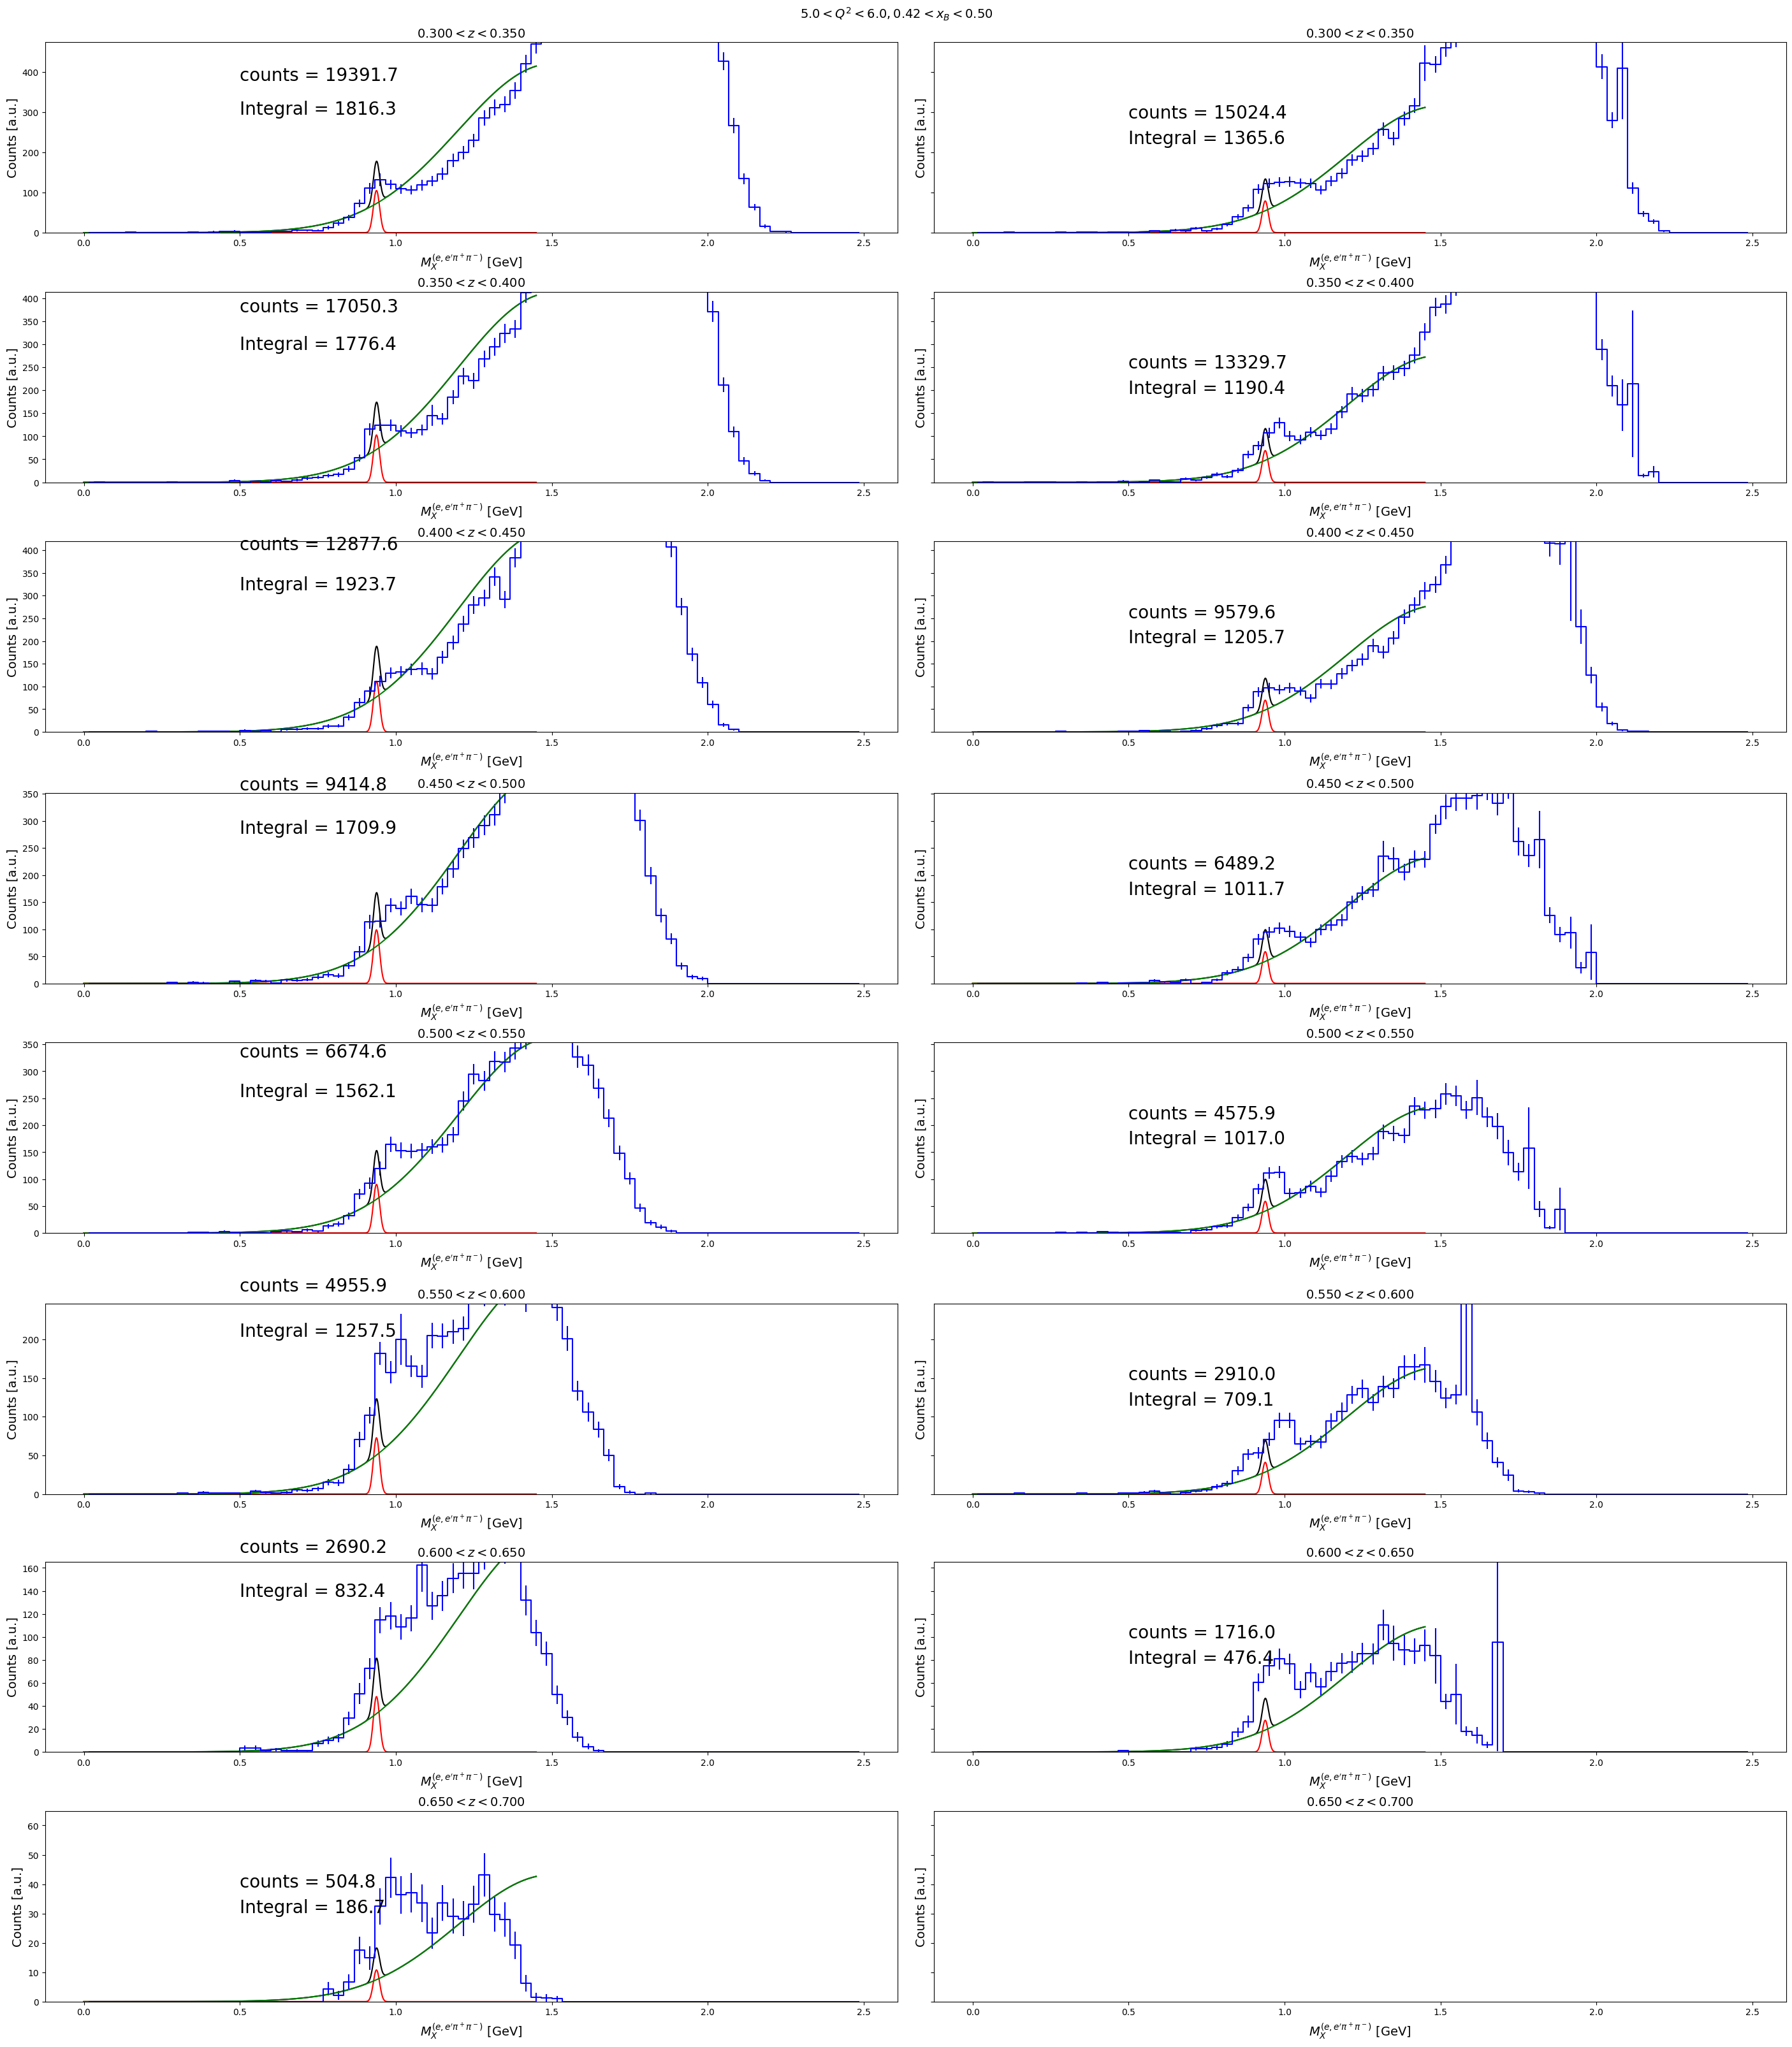

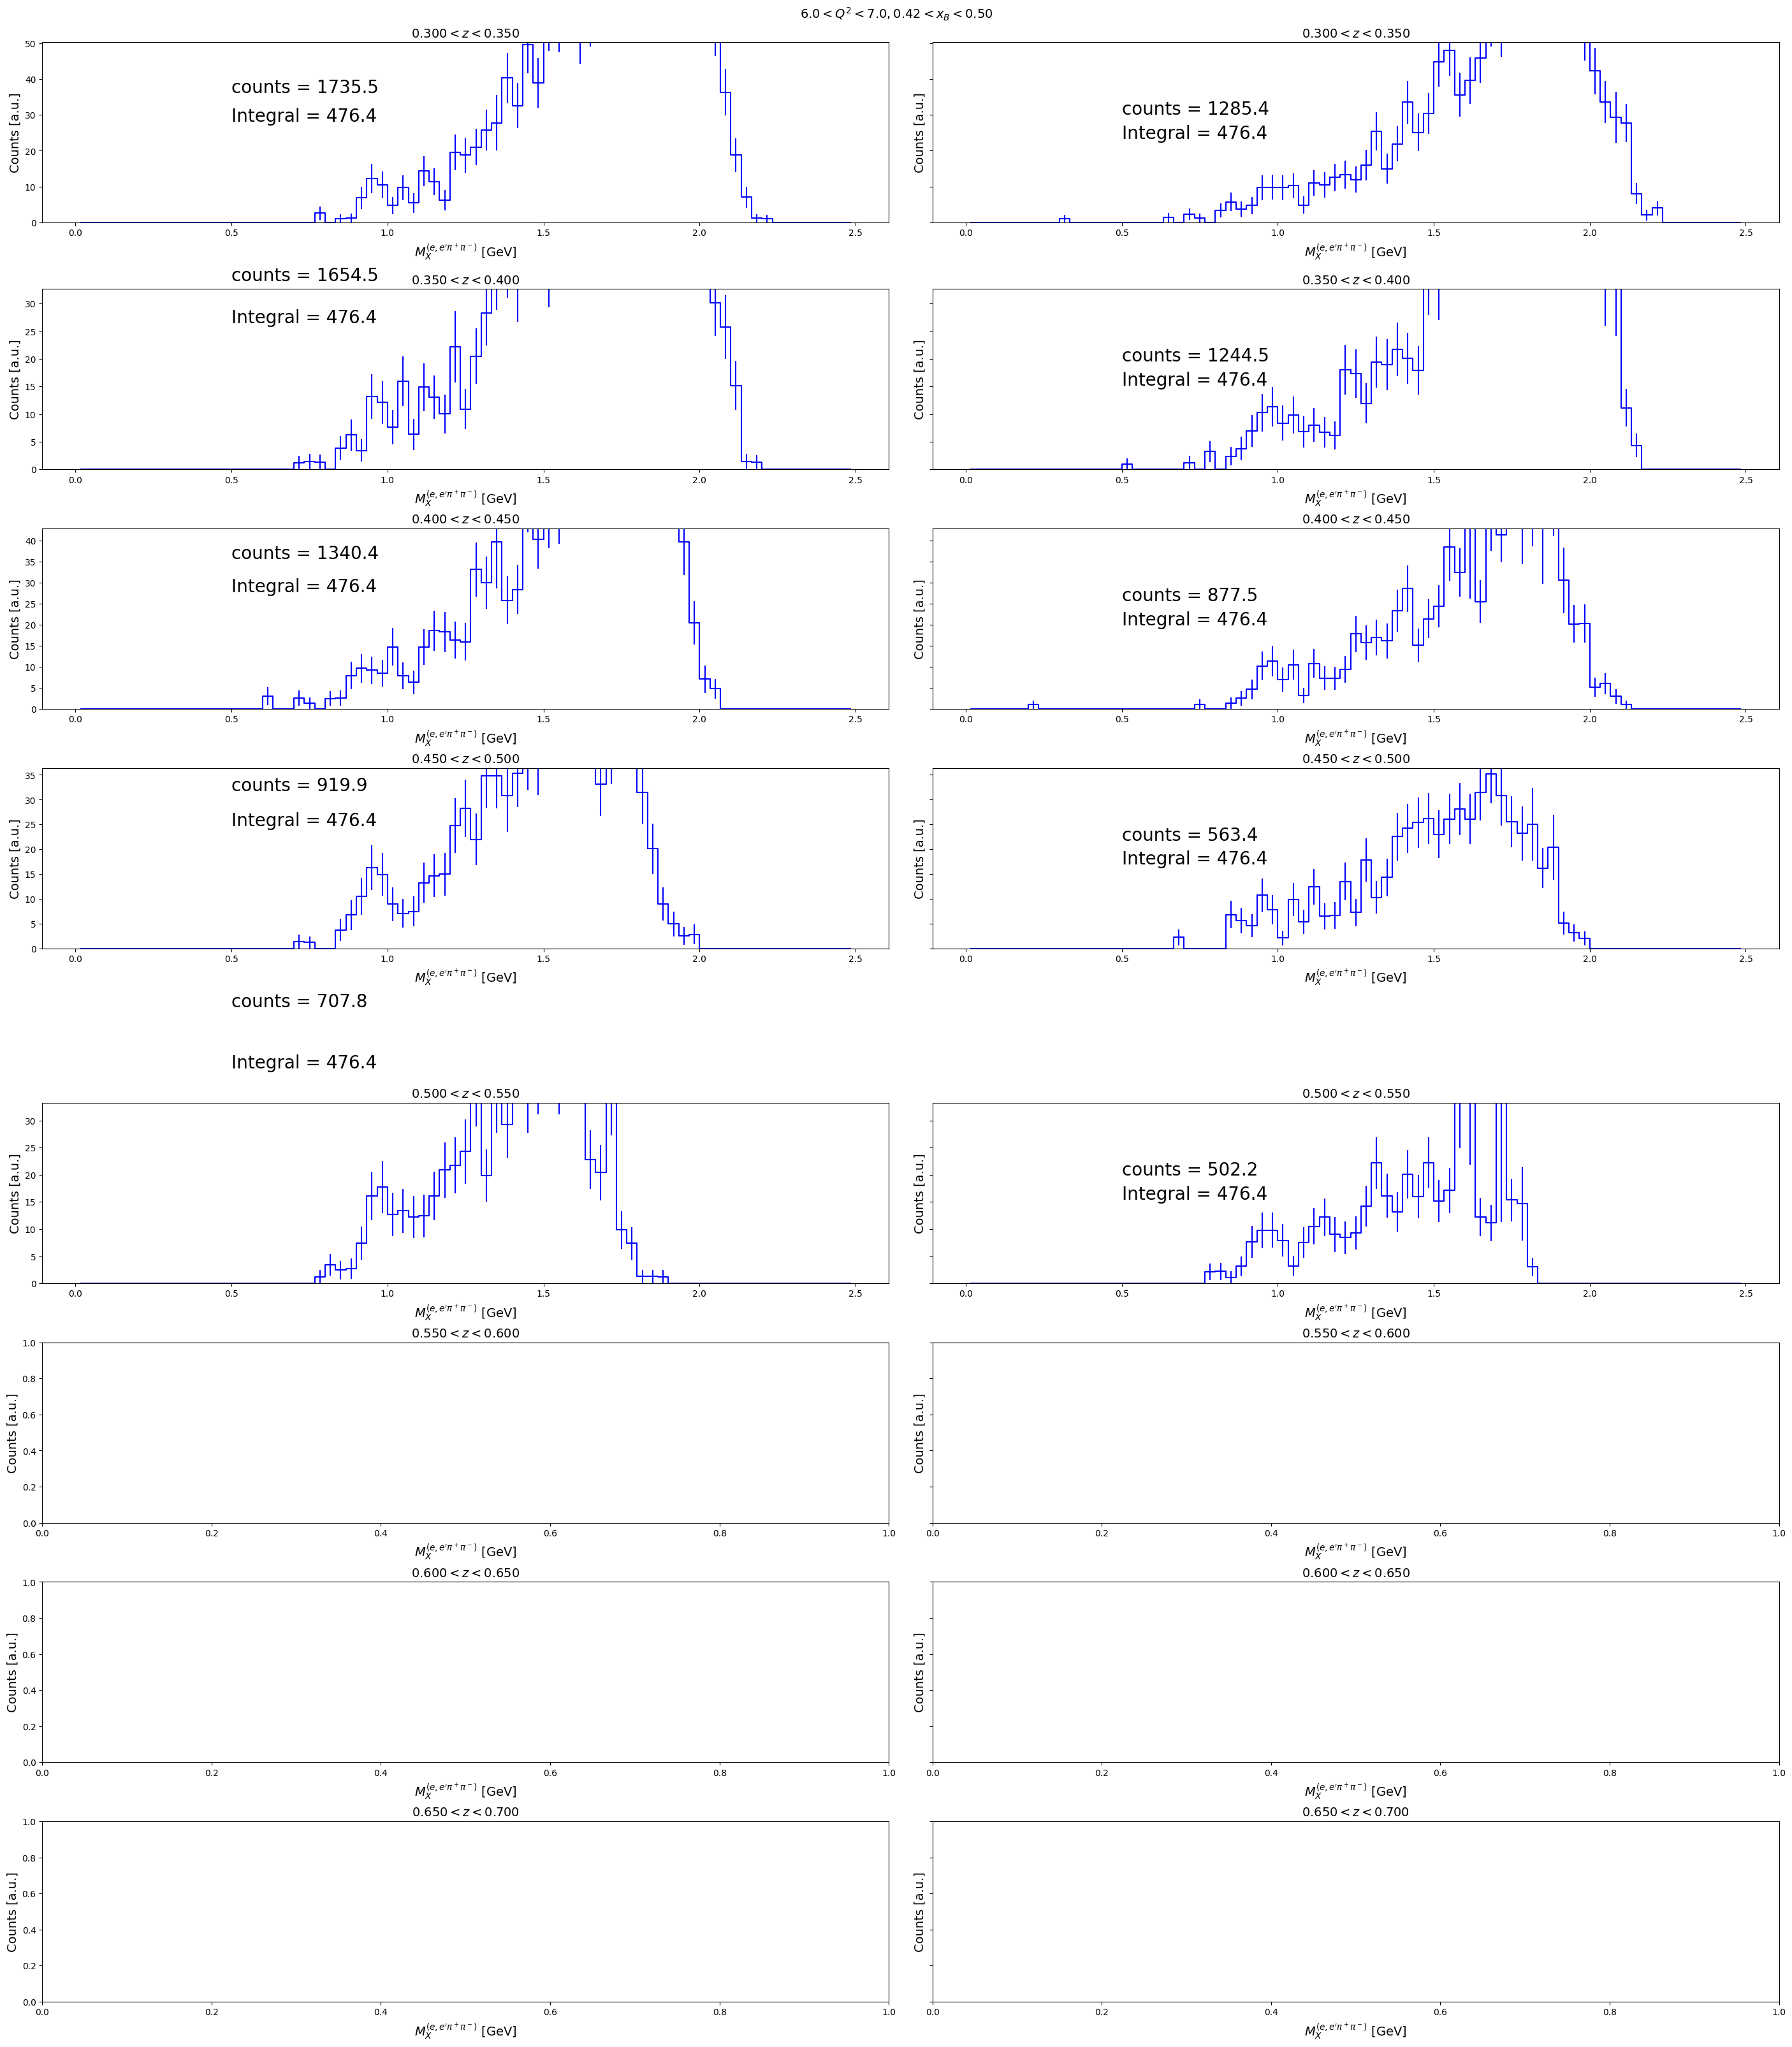

In [71]:
for x in range( 0, 5 ):
		
	for q in range( 0, 5 ):
		fig, axs = plt.subplots(8, 2, figsize=(28,32), layout='constrained', sharey='row', sharex='row')
		fig.suptitle( r"${0:.1f} < Q^2 < {1:.1f}, {2:.2f} < x_B < {3:.2f}$".format(2 + 1*q, 2 + 1*(q+1), .1 + .08*x, .1+0.08*(x+1)), fontsize=14)
		makePlot = False
		
		for charge in chargeSt:
			color = 'b'
			pltIdx = 0
			chIdx = ""
			if charge == 'p':
				chIdx = 0
			else:
				chIdx = 1
				pltIdx = 2
				#color = 'r'
			
			for z in range( 8 ):
				reg = z%8 
				ch = chIdx#math.floor(z/7)# + pltIdx
				axs[reg, ch].set_title(r"${0:.3f} < z < {1:.3f}$".format( .3 + .05*z, .3 + .05*(z+1)), fontsize=14 )
				axs[reg, ch].set_ylabel(r"Counts [a.u.]", fontsize=14)
				axs[reg, ch].set_xlabel(r"$M_{X}^{(e,e'\pi^+\pi^-)}$ [GeV]", fontsize=14)
				if f"hMx_pi{charge}_{x+1}_{q+1}_{z+1};1" not in key:
					continue
				if f"fMx_pi{charge}_{x+1}_{q+1}_{z+1};1" not in key:
					continue
				
				hist = inFile[f"hMx_pi{charge}_{x+1}_{q+1}_{z+1};1"]
				fFit = inFile_R.Get(f"fMx_pi{charge}_{x+1}_{q+1}_{z+1};1")
				
				
				values = hist.values()
				values[np.isnan(values)]=0
				#values[values == 0] = np.nan
				errors = hist.errors()
				#errors[errors==0] = np.nan
				if np.nansum(values) < 500:
					continue
				makePlot = True
				xEdges = hist.axis().edges()
				binCenters = (xEdges[:-1]+xEdges[1:])/2

				axs[reg, ch].errorbar(binCenters, values, errors, c=color ,drawstyle='steps-mid')
				
				xVals = np.linspace(0, 1.45, 1000)
				binCenters = binCenters[binCenters < 1.45]
				counts = [values[i] for i in range(len(binCenters))]
				uncs = np.sqrt(counts)
				p0 = [ np.nanmax(counts)/4., 0.938, 0.01,  np.nanmax(counts), 1.5, .3 ]
				
				if np.sum(counts) > 500:
					coeff, var_matrix = curve_fit(eval_func, np.asarray(binCenters), np.asarray(counts), p0=p0, sigma=uncs, absolute_sigma=True)
				
					axs[reg, ch].plot(xVals, eval_func(xVals, *coeff), color = 'k')
					axs[reg, ch].plot(xVals, eval_func_rho(coeff, xVals), color = 'r')
					axs[reg, ch].plot(xVals, eval_func_back(coeff, xVals), color = 'g')
				#axs[reg,ch].set_xlim(0, 1.3)
				axs[reg, ch].set_ylim(0, np.max(counts)*1.5)
				axs[reg, ch].text(0.5, 0.9*np.max(counts), 'counts = {0:.1f}'.format(np.nansum(values)), fontsize=20)
				axs[reg, ch].text(0.5, 0.7*np.max(counts), 'Integral = {0:.1f}'.format(np.nansum(eval_func_rho(coeff, xVals))), fontsize=20)

			if not makePlot:
				plt.close()
